# Density for different ages

see https://www.tng-project.org/data/docs/specifications/#parttype4

In [1]:
## Esto sale de density plots
import numpy as np
str_vmin = np.asarray([5.8,6.0,5.2,3.5,3.3,3.3,3.3,2.2,2.5,2.5,3.0,2.5,0.5,0.5,2.5])
str_vmax = np.asarray([9.2,9.2,8.9,8.7,8.7,8.7,8.7,8.7,7.5,7.5,7.0,7.0,7.5,7.5,7.5])
gas_vmin = np.asarray([6.0,5.5,5.7,4.8,4.7,5.0,4.7,4.5,4.6,4.6,4.6,4.3,4.5,4.5,4.5])
gas_vmax = np.asarray([8.0,7.5,7.6,7.7,7.4,7.5,7.5,7.5,7.3,7.3,7.3,7.0,7.5,7.3,7.0])
drk_vmin = np.asarray([6.7,6.7,6.2,6.0,5.5,5.7,5.6,5.6,5.5,5.5,5.8,5.5,5.5,5.5,5.5])
drk_vmax = np.asarray([9.3,9.0,8.9,9.0,9.0,9.0,9.0,9.0,8.3,8.3,8.0,8.0,8.0,8.5,8.5])

### NEW BINES

subhalo_127000000000002


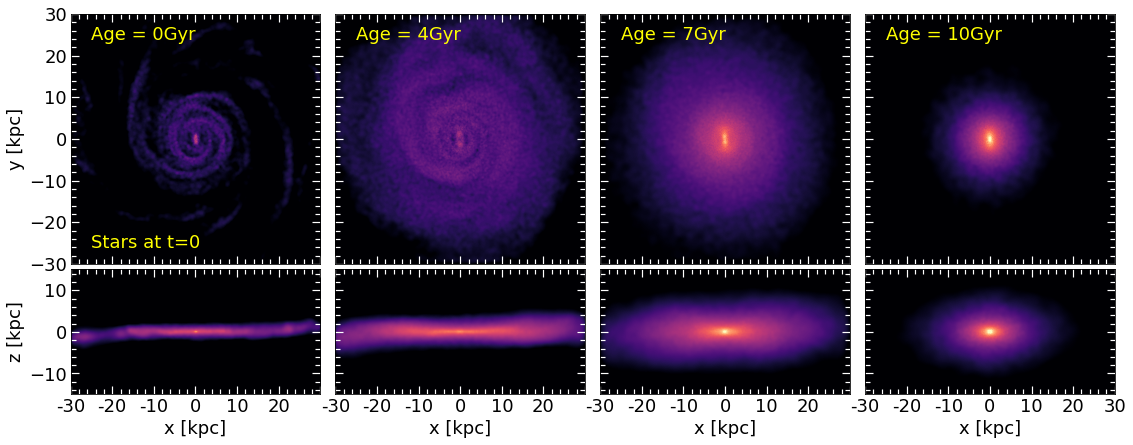

subhalo_127000000000003


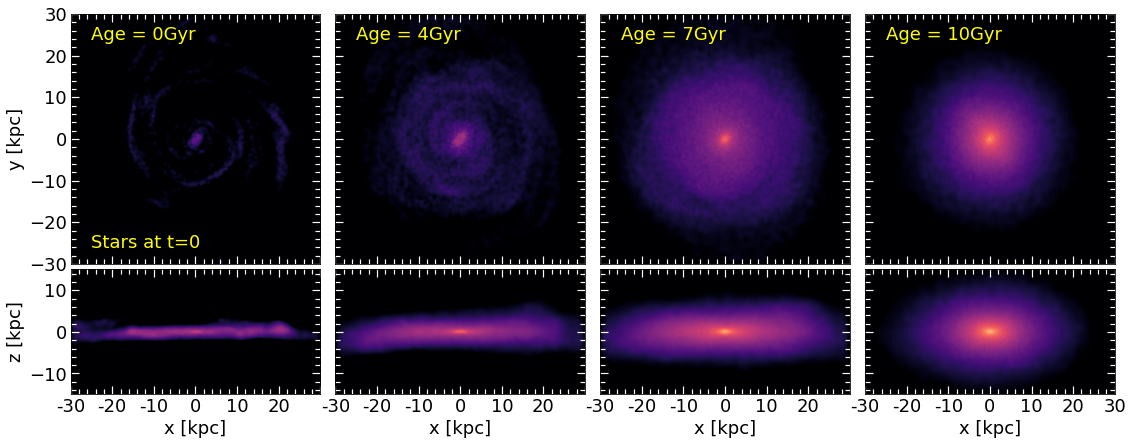

subhalo_127000000000004


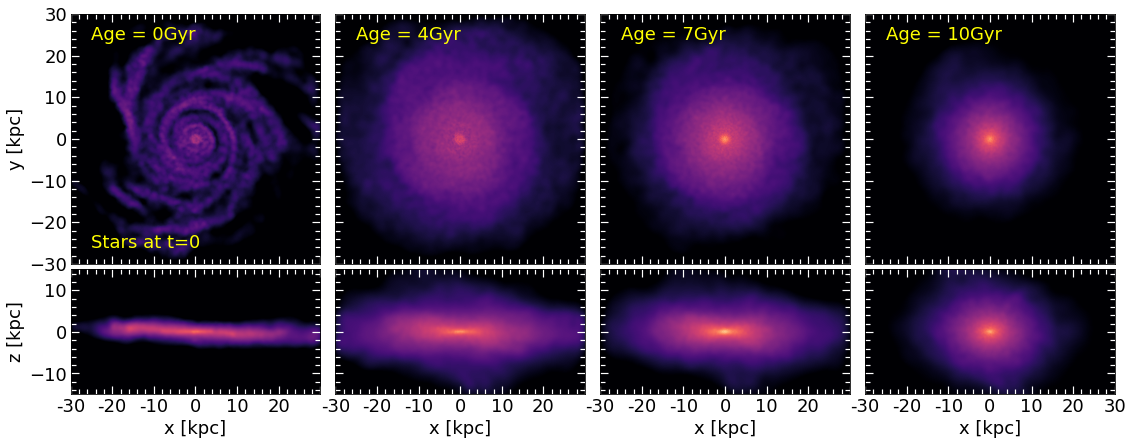

subhalo_127000000000006


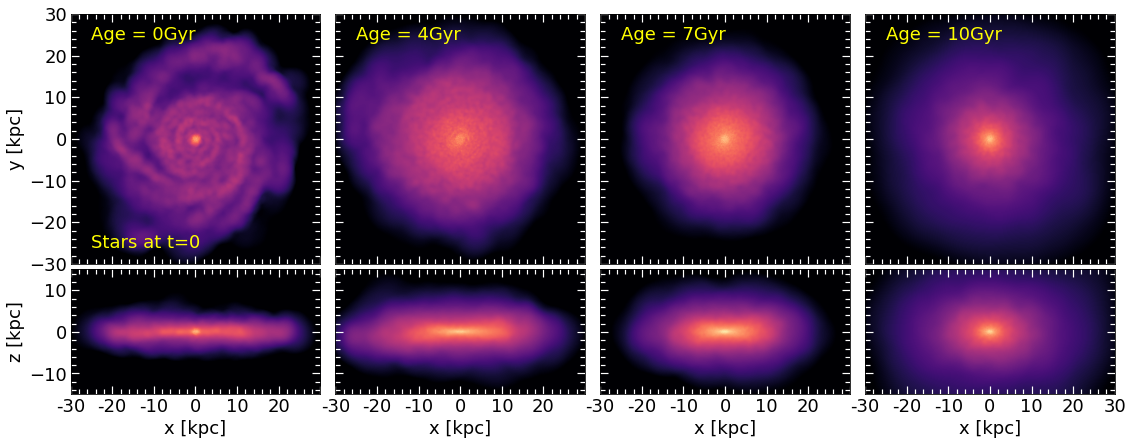

subhalo_127000000000007


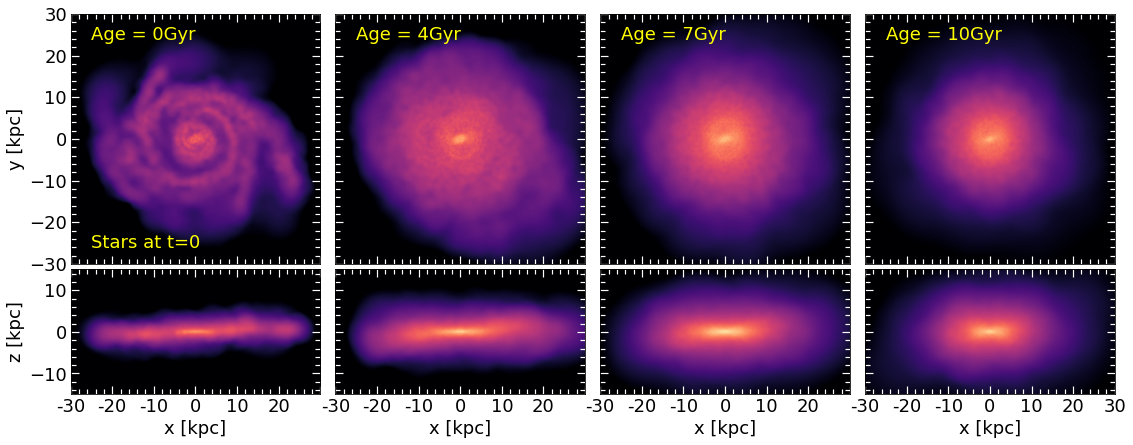

subhalo_127000000000009


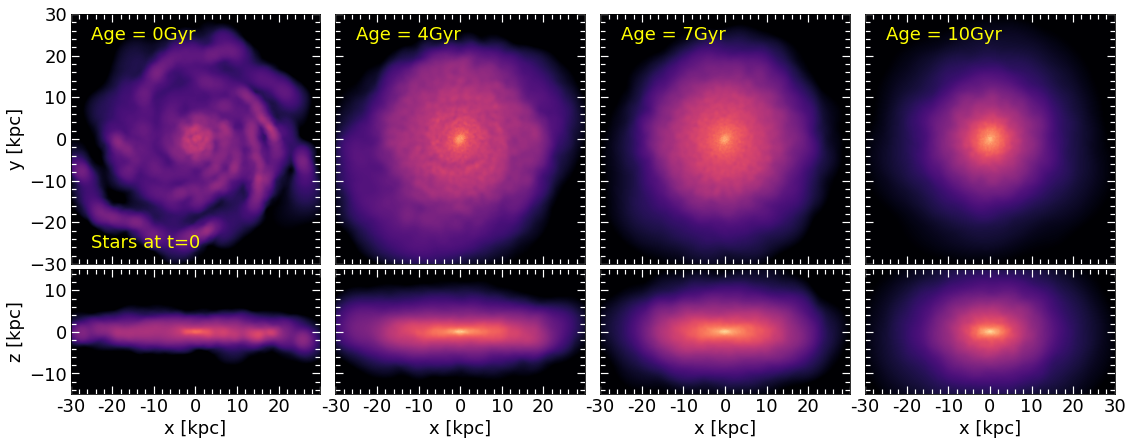

subhalo_127000000000012


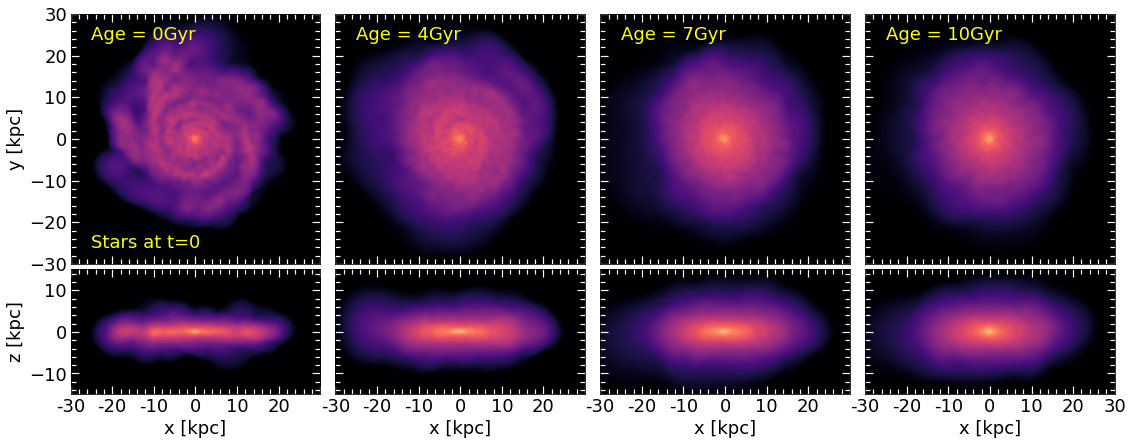

subhalo_127000000000011


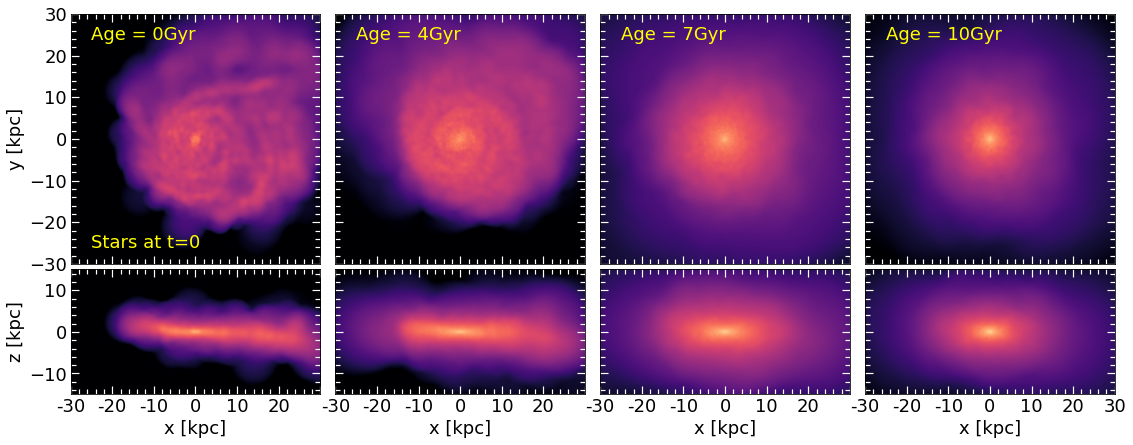

subhalo_127000000000014


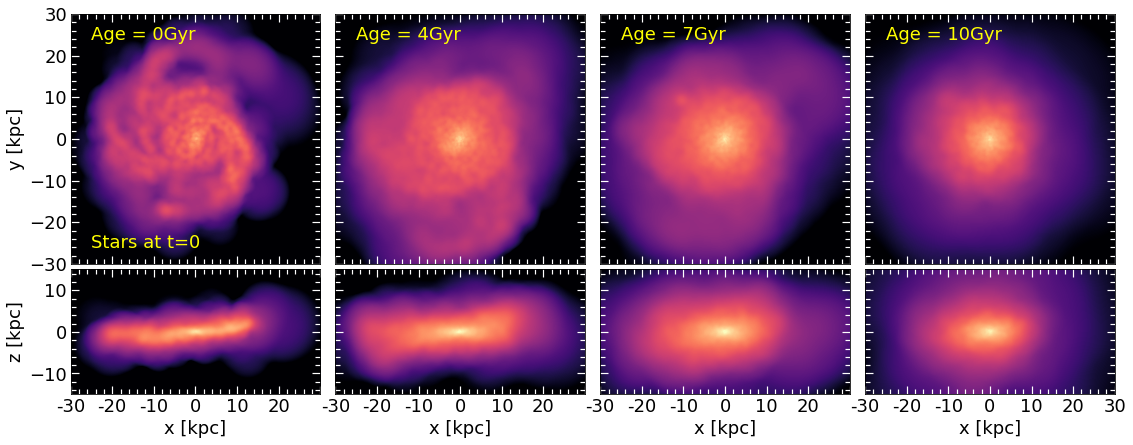

subhalo_127000000000020


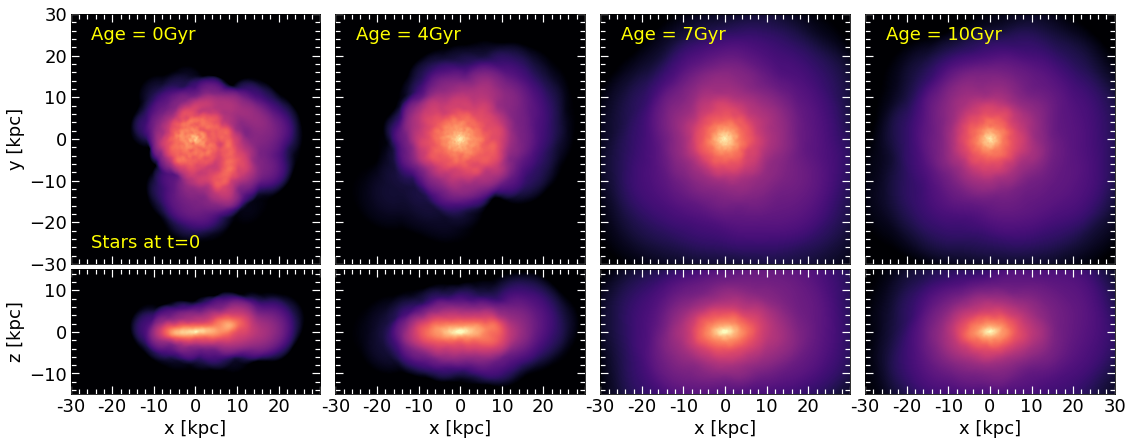

subhalo_127000000000021


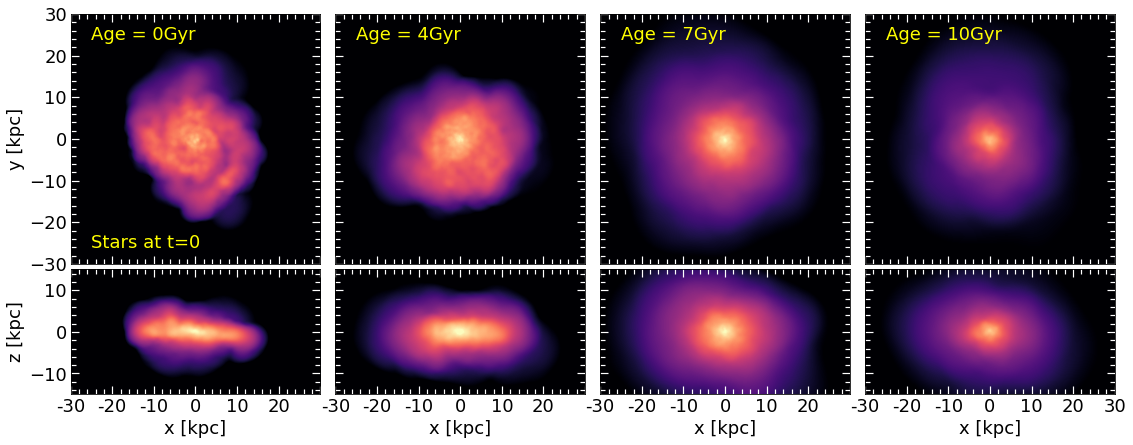

subhalo_127000000000023


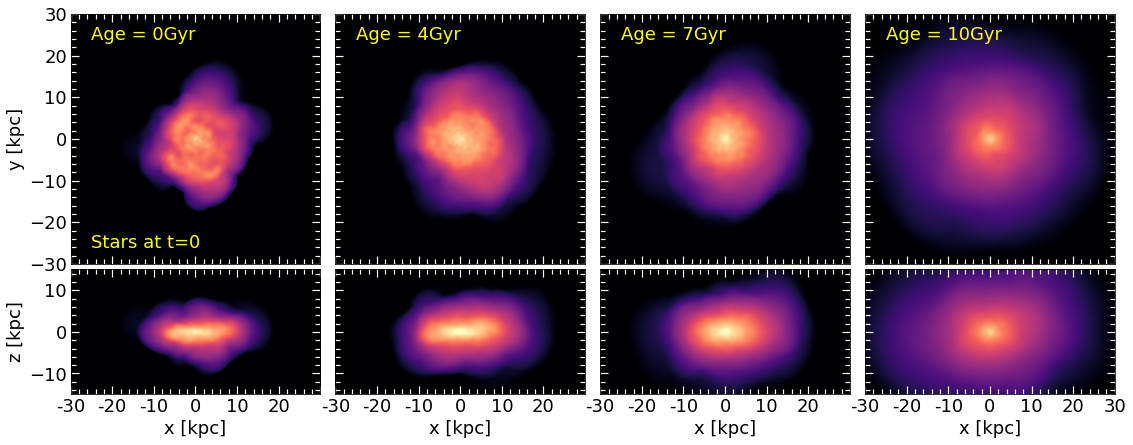

subhalo_127000000000028


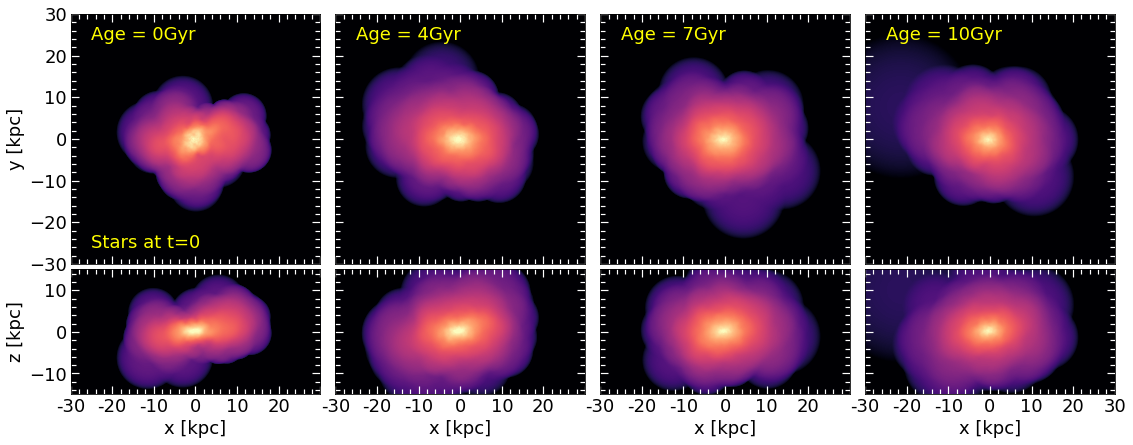

subhalo_127000000000031


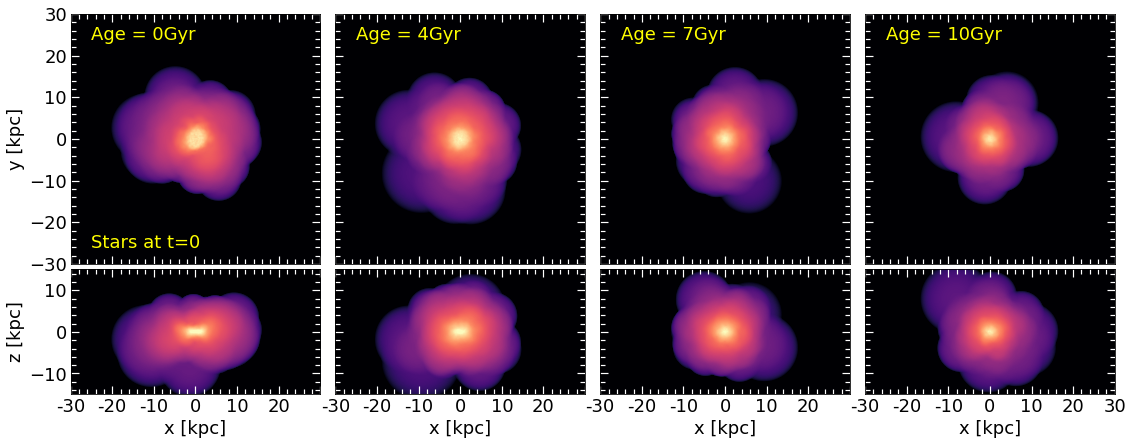

subhalo_127000000000030


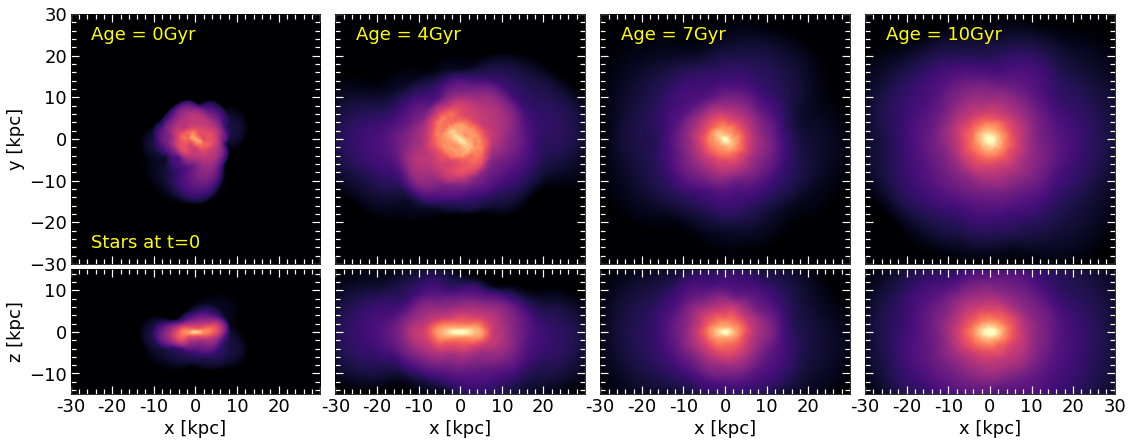

In [4]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import sphviewer as sph

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for i in range(15):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')
    
    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    IDs  = snap['/Str/IDs'][()]

    met  = snap['/Str/Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
#     aa   = ~np.isnan(ages) # me quedo con los que no son nan --> este no haria falta porque no daria nan porque no hay negativos.
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    FeH_ = met[amask,8]/met[amask,0] # Fe / H (hierro sobre hidrogeno)
    FeH  = FeH_/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)

    xstr = pstr[amask,0] * aexp/h
    ystr = pstr[amask,1] * aexp/h
    zstr = pstr[amask,2] * aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] * np.sqrt(aexp)
    v_y = vstr[amask,1] * np.sqrt(aexp)
    v_z = vstr[amask,2] * np.sqrt(aexp)
    
#     ID = IDs[amask]

    #----------------------masas----------------------------
    mstr = mstr[amask] * 1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc, = np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr

    Rstr = np.sqrt(xn_str**2 + yn_str**2)
    
    pos_str  = np.ndarray([np.size(xn_str),3])
    pos_str[:,0] = xn_str
    pos_str[:,1] = yn_str
    pos_str[:,2] = zn_str
    
    
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), 
                           gridspec_kw = {'height_ratios':[4,2], 'width_ratios':[4,4,4,4]})

    fig.subplots_adjust(bottom=0.1, left =0.05, right = 0.97, top = 0.98, wspace=-0.002, hspace= 0.03)

    #----------------------------------------------------------------------
    #---------------------generador del grafico1-----------------
    rl= 30   
    corte, = np.where((xn_str <rl) & (yn_str <rl) & (zn_str <rl) & (xn_str >-rl) & (yn_str >-rl) & (zn_str >-rl))
    
    age_0,  = np.where((age[corte] > 0.0) & (age[corte] < 0.5))
    age_4,  = np.where((age[corte] > 3.5) & (age[corte] < 4.5))
    age_7,  = np.where((age[corte] > 6.5) & (age[corte] < 7.5))
    age_10, = np.where((age[corte] > 9.5) & (age[corte] < 10.5))

    #-----rango que tiene la escala  de colores-----
    vmin = str_vmin[i]
    vmax = str_vmax[i]
    
    # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='magma'
    
    nb1 = 50
    #         nb1 = 100 
    #         npixel = 1000
    npixel = 1000

    particles=sph.Particles(pos_str[corte,:][age_0,:],mstr[corte][age_0],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()

    ax[0,0].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,0].set_xlim(-30,30)
    ax[0,0].set_ylim(-30,30)
    ax[0,0].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,0].set_yticks([])
#     ax[0,0].set_yticklabels([])
    ax[0,0].set_xticklabels([])
    ax[0,0].text(-25, 25, 'Age = 0Gyr', fontsize=18, color='yellow', ha='left', va='center') 
    ax[0,0].text(-25, -25, 'Stars at t=0', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,0].set_title('XY', loc='center', fontsize=18)
    ax[0,0].set_ylabel('y [kpc]', fontsize=18)
    ax[0,0].minorticks_on()
    ax[0,0].tick_params( labelsize=18)
    ax[0,0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,0].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_4,:],mstr[corte][age_4],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()
    
    ax[0,1].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,1].set_xlim(-30,30)
    ax[0,1].set_ylim(-30,30)
    ax[0,1].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,1].set_yticks([])
    ax[0,1].set_yticklabels([])
    ax[0,1].set_xticklabels([])
    ax[0,1].text(-25, 25, 'Age = 4Gyr', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,1].set_title('XY', loc='center', fontsize=18)
#     ax[0,1].set_ylabel('y [kpc]', fontsize=15)
    ax[0,1].minorticks_on()
    ax[0,1].tick_params( labelsize=18)
    ax[0,1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,1].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
   
    
    particles=sph.Particles(pos_str[corte,:][age_7,:],mstr[corte][age_7],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()
    
    ax[0,2].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,2].set_xlim(-30,30)
    ax[0,2].set_ylim(-30,30)
    ax[0,2].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,2].set_yticks([])
    ax[0,2].set_yticklabels([])
    ax[0,2].set_xticklabels([])
    ax[0,2].text(-25, 25, 'Age = 7Gyr', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,2].set_title('XY', loc='center', fontsize=18)
#     ax[0,2].set_ylabel('y [kpc]', fontsize=15)
    ax[0,2].minorticks_on()
    ax[0,2].tick_params( labelsize=18)
    ax[0,2].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,2].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')

    
    particles=sph.Particles(pos_str[corte,:][age_10,:],mstr[corte][age_10],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()
    
    ax[0,3].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,3].set_xlim(-30,30)
    ax[0,3].set_ylim(-30,30)
    ax[0,3].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,3].set_yticks([])
    ax[0,3].set_yticklabels([])
    ax[0,3].set_xticklabels([])
    ax[0,3].text(-25, 25, 'Age = 10Gyr', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,3].set_title('XY', loc='center', fontsize=18)
#     ax[0,3].set_ylabel('y [kpc]', fontsize=15)
    ax[0,3].minorticks_on()
    ax[0,3].tick_params( labelsize=18)
    ax[0,3].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,3].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    #--------------------------------------
    particles=sph.Particles(pos_str[corte,:][age_0,:],mstr[corte][age_0],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    # ax[0,0]=fig.add_subplot(221)
    ax[1,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,0].set_xlim(-30,30)
    ax[1,0].set_ylim(-15,15)
#     ax[1,0].set_xticks([])
    ax[1,0].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,0].set_xticklabels([-30,-20,-10,0,10,20])
#     ax[1,0].set_yticklabels([])
    ax[1,0].set_xlabel('x [kpc]',fontsize=18)
    ax[1,0].set_ylabel('z [kpc]',fontsize=18)
#     ax[1,0].set_title('XZ', loc='center', fontsize=18)
    ax[1,0].minorticks_on()
    ax[1,0].tick_params( labelsize=18)
    ax[1,0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,0].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_4,:],mstr[corte][age_4],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,1].set_xlim(-30,30)
    ax[1,1].set_ylim(-15,15)
    #     ax[1,1].set_xticks([])
    ax[1,1].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,1].set_xticklabels([-30,-20,-10,0,10,20])
    ax[1,1].set_yticklabels([])
    ax[1,1].set_xlabel('x [kpc]',fontsize=18)
#     ax[1,1].set_ylabel('z [kpc]',fontsize=15)
#     ax[1,1].set_title('XZ', loc='center', fontsize=18)
    ax[1,1].minorticks_on()
    ax[1,1].tick_params( labelsize=18)
    ax[1,1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,1].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_7,:],mstr[corte][age_7],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,2].set_xlim(-30,30)
    ax[1,2].set_ylim(-15,15)
    #     ax[1,2].set_xticks([])
    ax[1,2].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,2].set_xticklabels([-30,-20,-10,0,10,20])
    ax[1,2].set_yticklabels([])
    ax[1,2].set_xlabel('x [kpc]',fontsize=18)
#     ax[1,2].set_ylabel('z [kpc]',fontsize=15)
#     ax[1,2].set_title('XZ', loc='center', fontsize=18)
    ax[1,2].minorticks_on()
    ax[1,2].tick_params( labelsize=18)
    ax[1,2].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,2].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_10,:],mstr[corte][age_10],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1,3].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,3].set_xlim(-30,30)
    ax[1,3].set_ylim(-15,15)
    #     ax[1,2].set_xticks([])
    ax[1,3].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,3].set_xticklabels([-30,-20,-10,0,10,20,30])
    ax[1,3].set_yticklabels([])
    ax[1,3].set_xlabel('x [kpc]',fontsize=18)
#     ax[1,2].set_ylabel('z [kpc]',fontsize=15)
#     ax[1,2].set_title('XZ', loc='center', fontsize=18)
    ax[1,3].minorticks_on()
    ax[1,3].tick_params( labelsize=18)
    ax[1,3].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,3].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    path2 = '../_imagenes/ages_stars/new_bins/'
    fig.savefig(path2 + 'starages_sh_'+str('%d'%ID[i])+'.png', dpi = 100, xxbox_inches='tight')

    plt.show()


### OLD BINES

subhalo_127000000000002


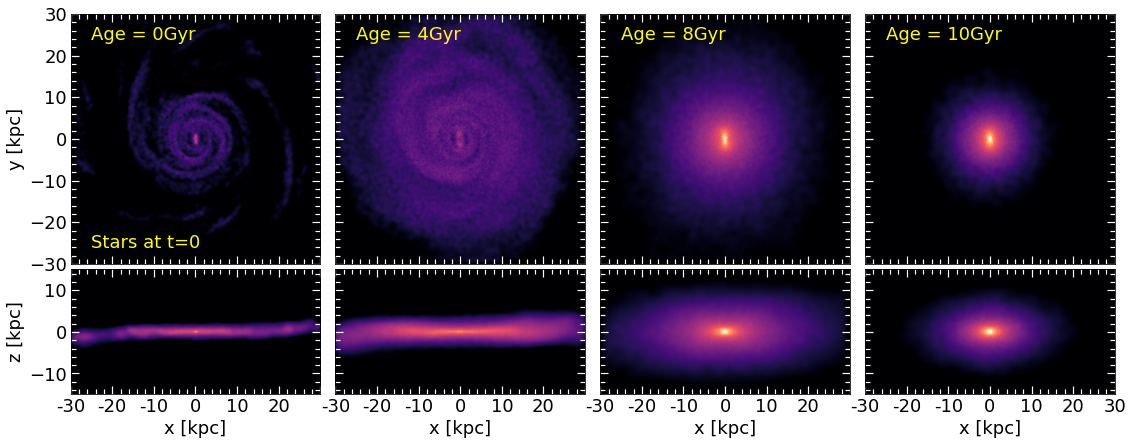

subhalo_127000000000003


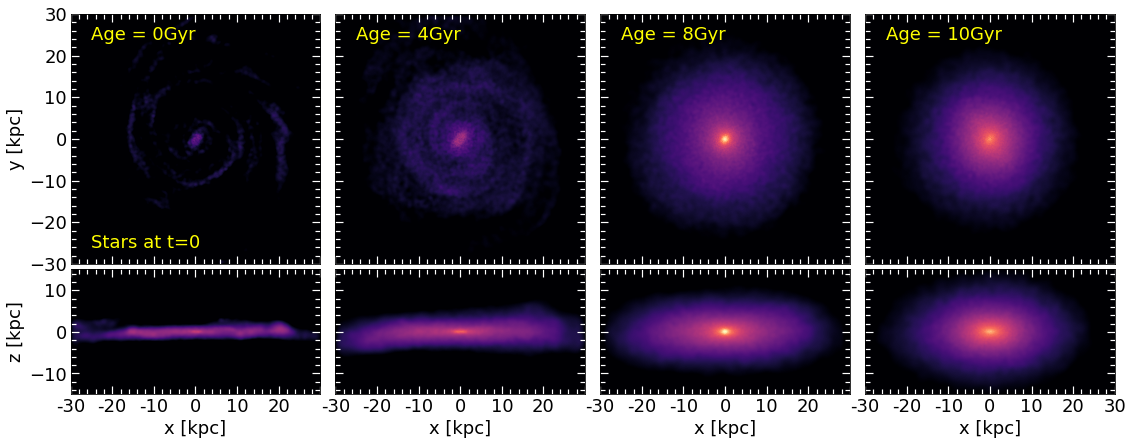

subhalo_127000000000004


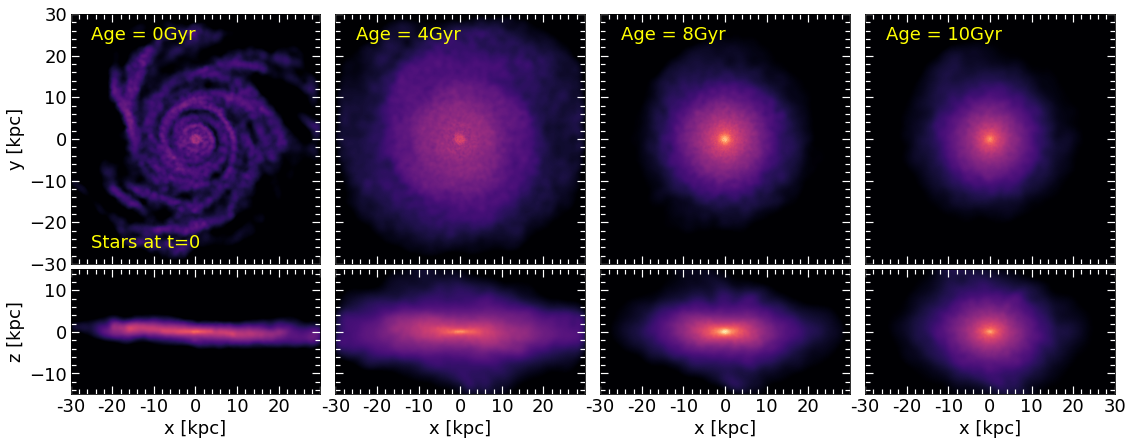

subhalo_127000000000006


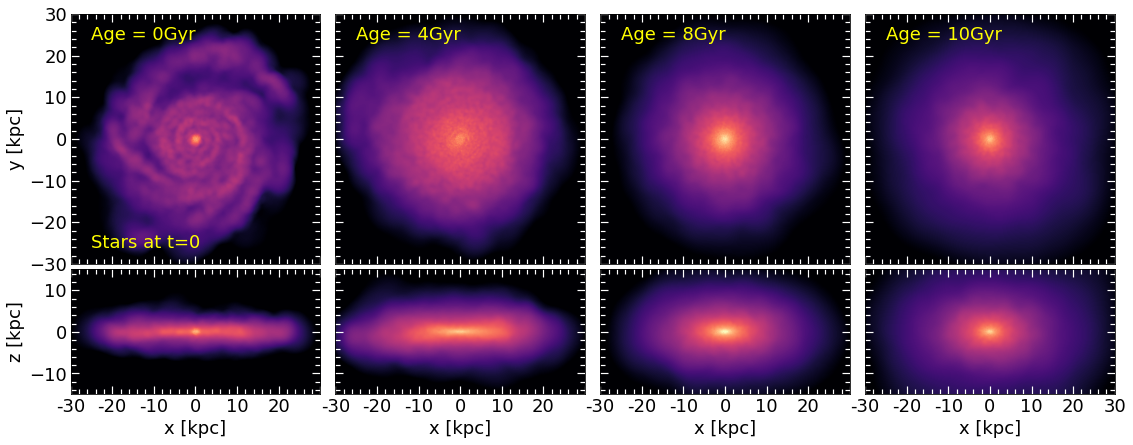

subhalo_127000000000007


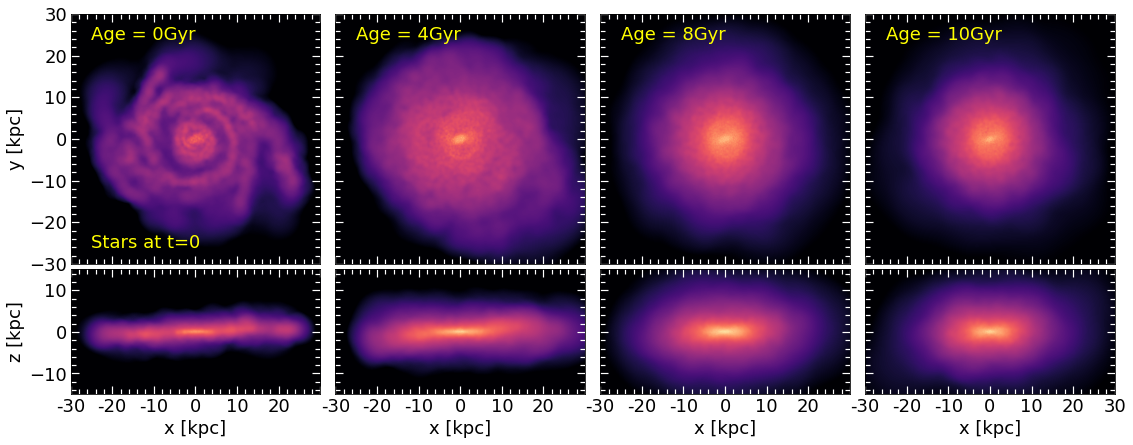

subhalo_127000000000009


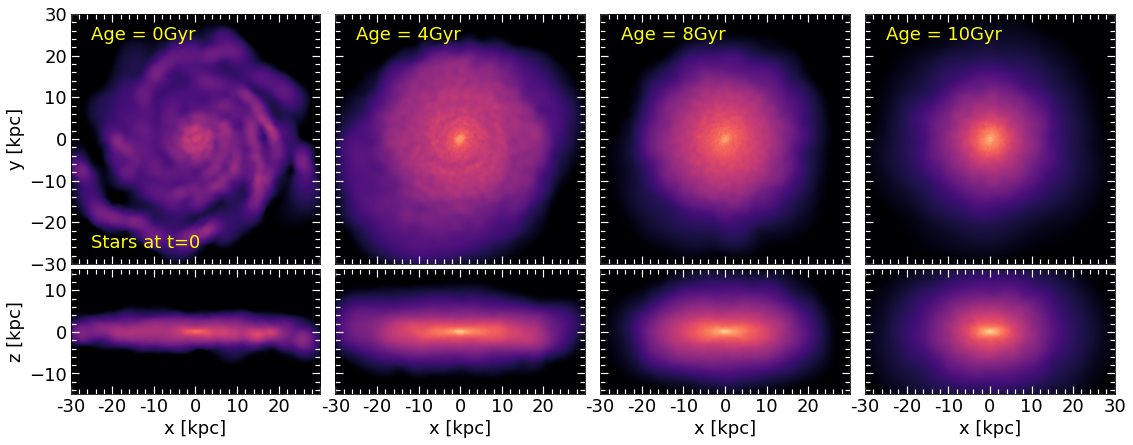

subhalo_127000000000012


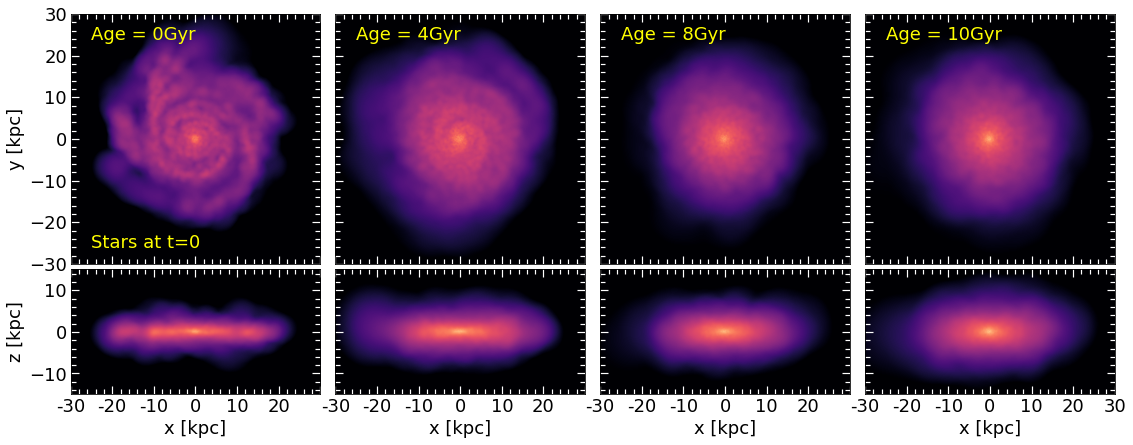

subhalo_127000000000011


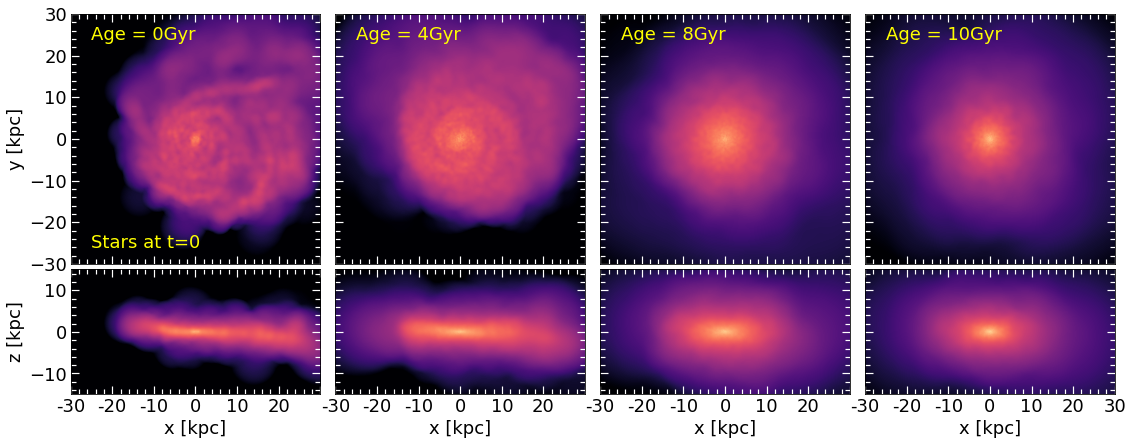

subhalo_127000000000014


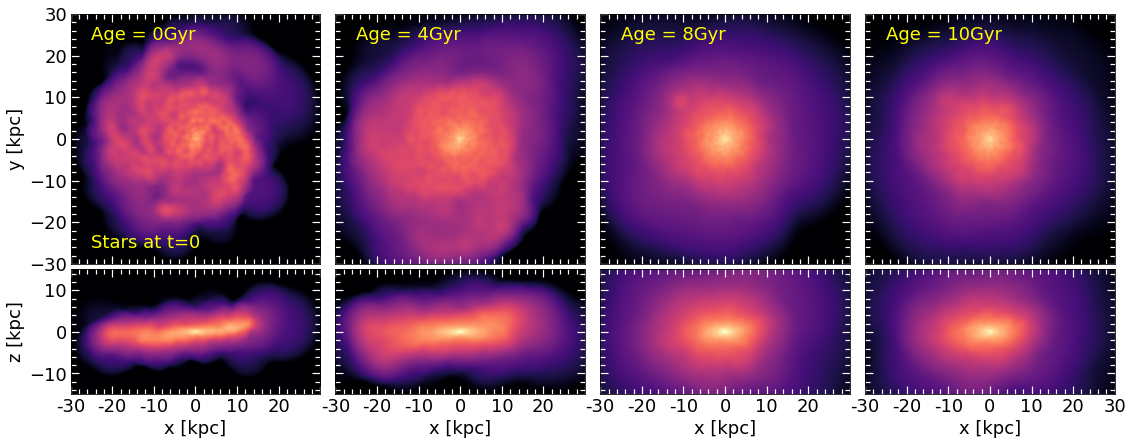

subhalo_127000000000020


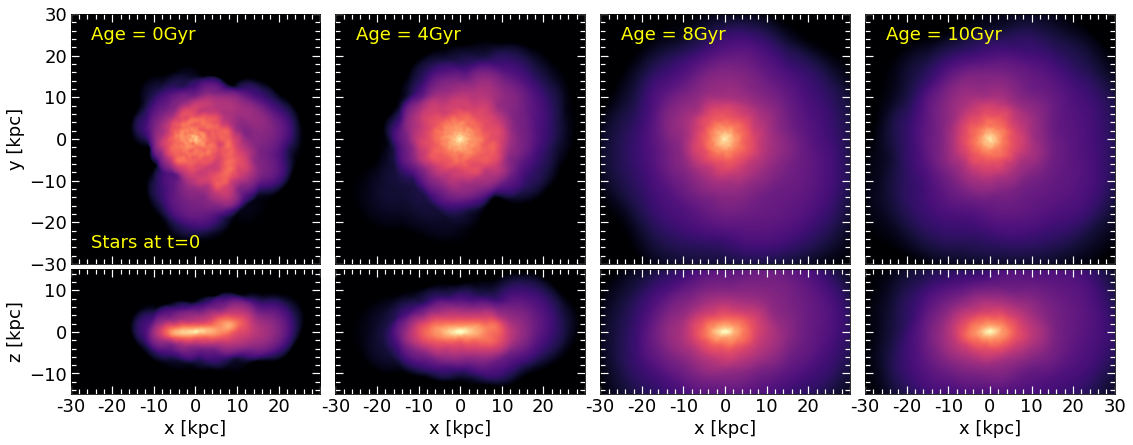

subhalo_127000000000021


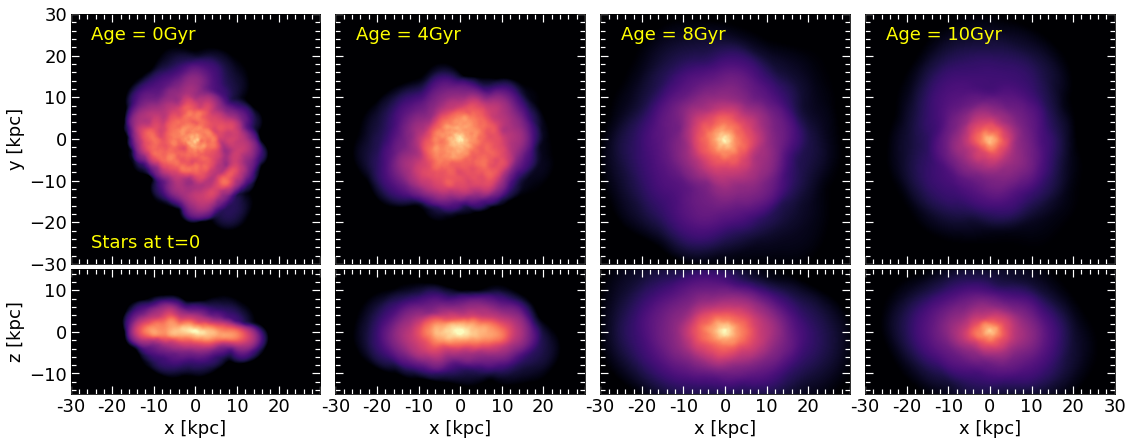

subhalo_127000000000023


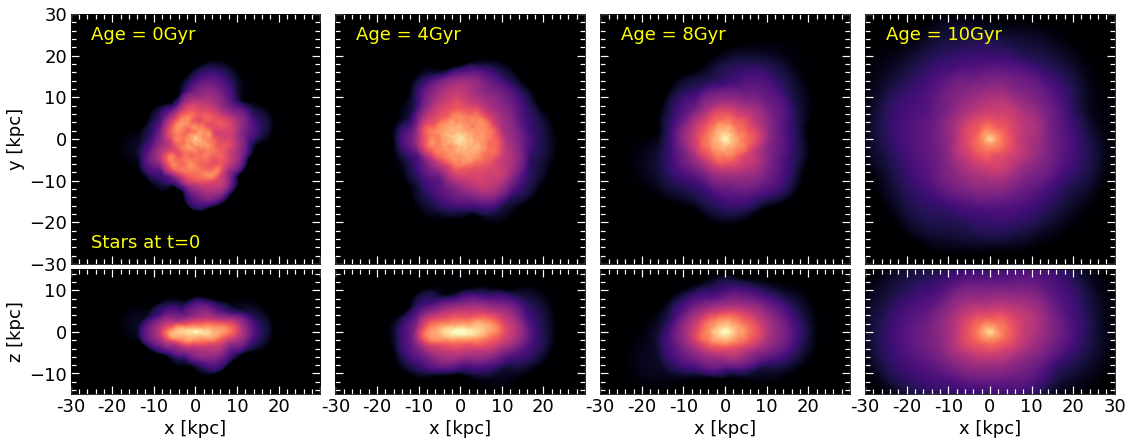

subhalo_127000000000028


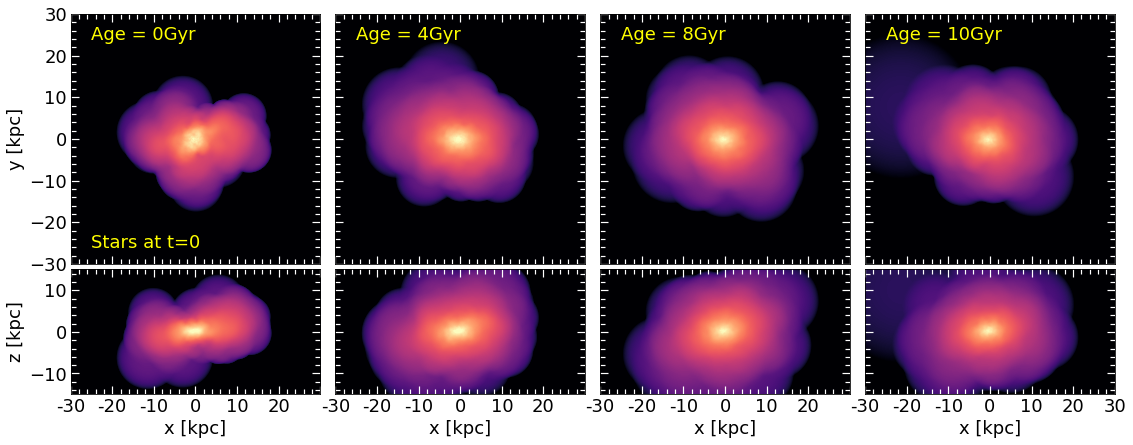

subhalo_127000000000031


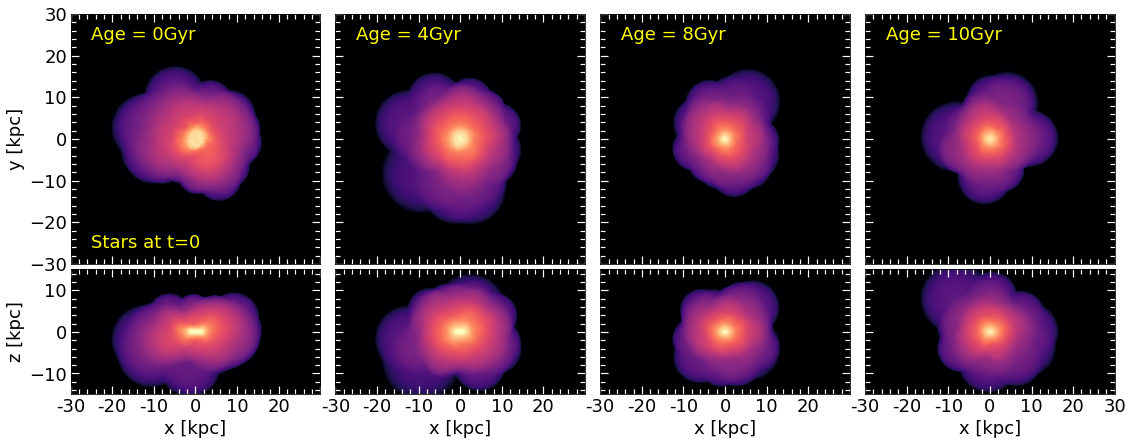

subhalo_127000000000030


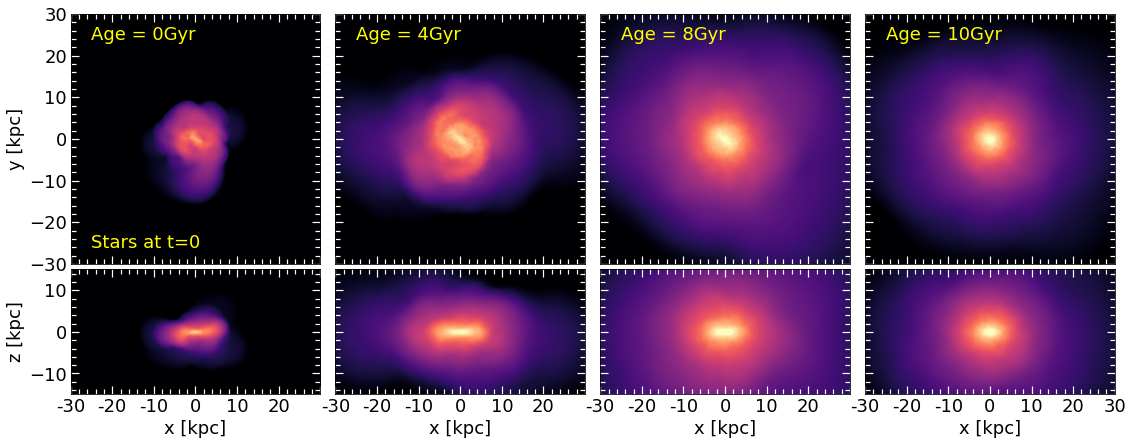

In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import sphviewer as sph

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for i in range(15):
    
    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')
    
    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    IDs  = snap['/Str/IDs'][()]

    met  = snap['/Str/Metallicity'][()]
    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
#     aa   = ~np.isnan(ages) # me quedo con los que no son nan --> este no haria falta porque no daria nan porque no hay negativos.
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    FeH_ = met[amask,8]/met[amask,0] # Fe / H (hierro sobre hidrogeno)
    FeH  = FeH_/0.0127 #para pasarlo a metalicidad solar (ver Illustris data)

    xstr = pstr[amask,0] * aexp/h
    ystr = pstr[amask,1] * aexp/h
    zstr = pstr[amask,2] * aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] * np.sqrt(aexp)
    v_y = vstr[amask,1] * np.sqrt(aexp)
    v_z = vstr[amask,2] * np.sqrt(aexp)
    
#     Id = IDs[amask]

    #----------------------masas----------------------------
    mstr = mstr[amask] * 1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc, = np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr

    Rstr = np.sqrt(xn_str**2 + yn_str**2)
    
    pos_str  = np.ndarray([np.size(xn_str),3])
    pos_str[:,0] = xn_str
    pos_str[:,1] = yn_str
    pos_str[:,2] = zn_str
    
    
    
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), 
                           gridspec_kw = {'height_ratios':[4,2], 'width_ratios':[4,4,4,4]})

    fig.subplots_adjust(bottom=0.1, left =0.05, right = 0.97, top = 0.98, wspace=-0.002, hspace= 0.03)

    #----------------------------------------------------------------------
    #---------------------generador del grafico1-----------------
    rl= 30   
    corte, = np.where((xn_str <rl) & (yn_str <rl) & (zn_str <rl) & (xn_str >-rl) & (yn_str >-rl) & (zn_str >-rl))
    
    age_0,  = np.where((age[corte] > 0.0) & (age[corte] < 0.5))
    age_4,  = np.where((age[corte] > 3.5) & (age[corte] < 4.5))
    age_8,  = np.where((age[corte] > 7.5) & (age[corte] < 8.5))
    age_10, = np.where((age[corte] > 9.5) & (age[corte] < 10.5))

    #-----rango que tiene la escala  de colores-----
    vmin = str_vmin[i]
    vmax = str_vmax[i]
    
    # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='magma'
    
    nb1 = 50
    #         nb1 = 100 
    #         npixel = 1000
    npixel = 1000

    particles=sph.Particles(pos_str[corte,:][age_0,:],mstr[corte][age_0],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()

    ax[0,0].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,0].set_xlim(-30,30)
    ax[0,0].set_ylim(-30,30)
    ax[0,0].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,0].set_yticks([])
#     ax[0,0].set_yticklabels([])
    ax[0,0].set_xticklabels([])
    ax[0,0].text(-25, 25, 'Age = 0Gyr', fontsize=18, color='yellow', ha='left', va='center') 
    ax[0,0].text(-25, -25, 'Stars at t=0', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,0].set_title('XY', loc='center', fontsize=18)
    ax[0,0].set_ylabel('y [kpc]', fontsize=18)
    ax[0,0].minorticks_on()
    ax[0,0].tick_params( labelsize=18)
    ax[0,0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,0].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_4,:],mstr[corte][age_4],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()
    
    ax[0,1].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,1].set_xlim(-30,30)
    ax[0,1].set_ylim(-30,30)
    ax[0,1].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,1].set_yticks([])
    ax[0,1].set_yticklabels([])
    ax[0,1].set_xticklabels([])
    ax[0,1].text(-25, 25, 'Age = 4Gyr', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,1].set_title('XY', loc='center', fontsize=18)
#     ax[0,1].set_ylabel('y [kpc]', fontsize=15)
    ax[0,1].minorticks_on()
    ax[0,1].tick_params( labelsize=18)
    ax[0,1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,1].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
   
    
    particles=sph.Particles(pos_str[corte,:][age_8,:],mstr[corte][age_8],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()
    
    ax[0,2].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,2].set_xlim(-30,30)
    ax[0,2].set_ylim(-30,30)
    ax[0,2].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,2].set_yticks([])
    ax[0,2].set_yticklabels([])
    ax[0,2].set_xticklabels([])
    ax[0,2].text(-25, 25, 'Age = 8Gyr', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,2].set_title('XY', loc='center', fontsize=18)
#     ax[0,2].set_ylabel('y [kpc]', fontsize=15)
    ax[0,2].minorticks_on()
    ax[0,2].tick_params( labelsize=18)
    ax[0,2].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,2].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')

    
    particles=sph.Particles(pos_str[corte,:][age_10,:],mstr[corte][age_10],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    extent=escena.get_extent()
    rend0.set_logscale()
    
    ax[0,3].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[0,3].set_xlim(-30,30)
    ax[0,3].set_ylim(-30,30)
    ax[0,3].set_xticks([-30,-20,-10,0,10,20,30])
#     ax[0,3].set_yticks([])
    ax[0,3].set_yticklabels([])
    ax[0,3].set_xticklabels([])
    ax[0,3].text(-25, 25, 'Age = 10Gyr', fontsize=18, color='yellow', ha='left', va='center') 
#     ax[0,3].set_title('XY', loc='center', fontsize=18)
#     ax[0,3].set_ylabel('y [kpc]', fontsize=15)
    ax[0,3].minorticks_on()
    ax[0,3].tick_params( labelsize=18)
    ax[0,3].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[0,3].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    #--------------------------------------
    particles=sph.Particles(pos_str[corte,:][age_0,:],mstr[corte][age_0],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    # ax[0,0]=fig.add_subplot(221)
    ax[1,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,0].set_xlim(-30,30)
    ax[1,0].set_ylim(-15,15)
#     ax[1,0].set_xticks([])
    ax[1,0].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,0].set_xticklabels([-30,-20,-10,0,10,20])
#     ax[1,0].set_yticklabels([])
    ax[1,0].set_xlabel('x [kpc]',fontsize=18)
    ax[1,0].set_ylabel('z [kpc]',fontsize=18)
#     ax[1,0].set_title('XZ', loc='center', fontsize=18)
    ax[1,0].minorticks_on()
    ax[1,0].tick_params( labelsize=18)
    ax[1,0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,0].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_4,:],mstr[corte][age_4],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,1].set_xlim(-30,30)
    ax[1,1].set_ylim(-15,15)
    #     ax[1,1].set_xticks([])
    ax[1,1].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,1].set_xticklabels([-30,-20,-10,0,10,20])
    ax[1,1].set_yticklabels([])
    ax[1,1].set_xlabel('x [kpc]',fontsize=18)
#     ax[1,1].set_ylabel('z [kpc]',fontsize=15)
#     ax[1,1].set_title('XZ', loc='center', fontsize=18)
    ax[1,1].minorticks_on()
    ax[1,1].tick_params( labelsize=18)
    ax[1,1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,1].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_8,:],mstr[corte][age_8],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,2].set_xlim(-30,30)
    ax[1,2].set_ylim(-15,15)
    #     ax[1,2].set_xticks([])
    ax[1,2].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,2].set_xticklabels([-30,-20,-10,0,10,20])
    ax[1,2].set_yticklabels([])
    ax[1,2].set_xlabel('x [kpc]',fontsize=18)
#     ax[1,2].set_ylabel('z [kpc]',fontsize=15)
#     ax[1,2].set_title('XZ', loc='center', fontsize=18)
    ax[1,2].minorticks_on()
    ax[1,2].tick_params( labelsize=18)
    ax[1,2].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,2].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    
    particles=sph.Particles(pos_str[corte,:][age_10,:],mstr[corte][age_10],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax[1,3].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax[1,3].set_xlim(-30,30)
    ax[1,3].set_ylim(-15,15)
    #     ax[1,2].set_xticks([])
    ax[1,3].set_xticks([-30,-20,-10,0,10,20,30])
    ax[1,3].set_xticklabels([-30,-20,-10,0,10,20,30])
    ax[1,3].set_yticklabels([])
    ax[1,3].set_xlabel('x [kpc]',fontsize=18)
#     ax[1,2].set_ylabel('z [kpc]',fontsize=15)
#     ax[1,2].set_title('XZ', loc='center', fontsize=18)
    ax[1,3].minorticks_on()
    ax[1,3].tick_params( labelsize=18)
    ax[1,3].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
    ax[1,3].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')
    
    path2 = '../_imagenes/ages_stars/'
    fig.savefig(path2 + 'starages_sh_'+str('%d'%ID[i])+'.png', dpi = 100, xxbox_inches='tight')

    plt.show()


#### Aca veo que snapshots caen dentro de cada bin de edad

In [2]:
import numpy as np

data = np.loadtxt('../_data/time.dat')
snap = data[:,0]
T = data[:,3]

ages = np.array([0,4,7,10])
time = 13.68449532 - ages


mask_0,  = np.where((T > time[0]-0.5) & (T < time[0]))
mask_4,  = np.where((T > time[1]-0.5) & (T < time[1]+0.5))
mask_7,  = np.where((T > time[2]-0.5) & (T < time[2]+0.5))
mask_10, = np.where((T > time[3]-0.5) & (T < time[3]+0.5))

print(T[mask_0],snap[mask_0])
print(T[mask_4],snap[mask_4])
print(T[mask_7],snap[mask_7])
print(T[mask_10],snap[mask_10])

[13.49046345 13.36181792] [126. 125.]
[10.07531841  9.91144662  9.74929595  9.58888109  9.43021578  9.27331277] [105. 104. 103. 102. 101. 100.]
[7.05142171 6.88304876 6.75889127 6.59616586 6.43664521 6.28030977] [86. 85. 84. 83. 82. 81.]
[4.13413574 4.00225006 3.84913115 3.70147896 3.53592207 3.3995865
 3.24681186] [67. 66. 65. 64. 63. 62. 61.]


### Saco los ID de las particulas que nacieron en cada bin de edades

#### Tambien guardo la cantidad de particulas que hay en cada bin


In [19]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import sphviewer as sph

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127'

for i in range(15):   
    snap = h5py.File(path +'/subhalo_'+ str('%d'%ID[i]) +'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr  = snap['/Str/Coordinates'][()]
    mstr  = snap['/Str/Masses'][()]
    vstr  = snap['/Str/Velocities'][()]
    IDstr = snap['/Str/IDs'][()]

    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    #     aa   = ~np.isnan(ages) # me quedo con los que no son nan --> este no haria falta porque no daria nan porque no hay negativos.
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    id_str = IDstr[amask]

    xstr = pstr[amask,0] * aexp/h
    ystr = pstr[amask,1] * aexp/h
    zstr = pstr[amask,2] * aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] * np.sqrt(aexp)
    v_y = vstr[amask,1] * np.sqrt(aexp)
    v_z = vstr[amask,2] * np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask] * 1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr

    Rstr = np.sqrt(xn_str**2 + yn_str**2)
    rn_str = np.sqrt(xn_str**2 + yn_str**2)
    pos_str  = np.ndarray([np.size(xn_str),3])
    pos_str[:,0] = xn_str
    pos_str[:,1] = yn_str
    pos_str[:,2] = zn_str

    #     fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7,18))

    #     fig.subplots_adjust(bottom=0.1, left =0.05, right = 0.97, top = 0.98, wspace=-0.002, hspace= 0.03)

    #----------------------------------------------------------------------
    #---------------------generador del grafico1-----------------

    corte, = np.where(rn_str < rgal)

    age_0,  = np.where((age[corte] > 0.0) & (age[corte] < 0.5))
    age_4,  = np.where((age[corte] > 3.5) & (age[corte] < 4.5))
    age_7,  = np.where((age[corte] > 6.5) & (age[corte] < 7.5))
    age_10, = np.where((age[corte] > 9.5) & (age[corte] < 10.5))

    ID_0 = id_str[corte][age_0]
    ID_4 = id_str[corte][age_4]
    ID_7 = id_str[corte][age_7]
    ID_10 = id_str[corte][age_10]

    n_0 = len(ID_0)
    n_4 = len(ID_4)
    n_7 = len(ID_7)
    n_10 = len(ID_10)

    n_tot = n_0 + n_4 + n_7 + n_10

    id_total = np.ndarray([n_tot])
    id_total[0:n_0] = ID_0
    id_total[n_0:n_0 + n_4] = ID_4
    id_total[n_0 + n_4:n_0 + n_4 + n_7] = ID_7
    id_total[n_0 + n_4 + n_7:n_tot] = ID_10

    ntotal = np.array([n_0,n_4,n_7,n_10])
    
    np.savetxt('../_data/ID_partxagebin/ID_pxab_sh_'+str('%d'%ID[i])+'.dat', 
               id_total,fmt='%10d')
    np.savetxt('../_data/ID_partxagebin/npxab_sh'+str('%d'%ID[i])+'.dat', 
               ntotal, fmt='%7d')

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023
subhalo_127000000000028
subhalo_127000000000031
subhalo_127000000000030


### Guardo en que snapshot se formo cada particula

In [22]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import sphviewer as sph

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127'

data = np.loadtxt('../_data/time.dat')
s = data[:,0]
T = data[:,3]

for i in range(1):   
    snap = h5py.File(path +'/subhalo_'+ str('%d'%ID[i]) +'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[i]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr  = snap['/Str/Coordinates'][()]
    mstr  = snap['/Str/Masses'][()]
    vstr  = snap['/Str/Velocities'][()]
    IDstr = snap['/Str/IDs'][()]

    sft  = snap['/Str/FormationTime'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    #     aa   = ~np.isnan(ages) # me quedo con los que no son nan --> este no haria falta porque no daria nan porque no hay negativos.
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    id_str = IDstr[amask]

    xstr = pstr[amask,0] * aexp/h
    ystr = pstr[amask,1] * aexp/h
    zstr = pstr[amask,2] * aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] * np.sqrt(aexp)
    v_y = vstr[amask,1] * np.sqrt(aexp)
    v_z = vstr[amask,2] * np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask] * 1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr

    Rstr = np.sqrt(xn_str**2 + yn_str**2)
    rn_str = np.sqrt(xn_str**2 + yn_str**2)
    pos_str  = np.ndarray([np.size(xn_str),3])
    pos_str[:,0] = xn_str
    pos_str[:,1] = yn_str
    pos_str[:,2] = zn_str

    corte, = np.where(rn_str < rgal)
    
    orden = np.argsort(ages[corte])
    
    sft_ordered = ages[corte][orden][::-1]
    id_ordered  = id_str[corte][orden][::-1]

    Snaps = np.zeros(len(sft_ordered))
    Times = np.zeros(len(sft_ordered))
    
    for k in range(len(sft_ordered)):
        if sft_ordered[k] != sft_ordered[k-1]:
            for j in range(len(T)-1):
                if ((sft_ordered[k] < T[j]) & (sft_ordered[k] > T[j+1])):
                    Snaps[k] = s[j]
                    Times[k] = T[j]
                    break
        else: 
            Snaps[k] = s[j]
            Times[k] = T[j]
                                                                          

    data = np.ndarray([len(ages[corte]),4])
    data[:,0] = Snaps
    data[:,1] = Times
    data[:,2] = sft_ordered
    data[:,3] = id_ordered

#     np.savetxt('../_data/snap_sft/sft_snap_sh'+ str('%d'%ID[i])+'.dat', 
#                data, fmt=('%3d','%2.8f', '%2.8f','%10d'))

subhalo_127000000000002


### Voy a guardar masas y posiciones de las particulas en su snapshot de formacion

In [52]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import sphviewer as sph

shID = np.loadtxt('../_data/my_halos.dat')[:,0]
tiempos = np.loadtxt('../_data/time.dat')
s = tiempos[:,0]

path = '/z/omarioni/gradients/_simulations/snap_'


for i in range(2,15):
    
    f = open('../_data/pos_part_age/output_data.dat', 'a')
    
    print('subhalo_'+str('%d'%shID[i]))
    f.write('subhalo_'+str('%d'%shID[i]) + '\n')
    
    sft_snap = np.loadtxt('../_data/snap_sft/sft_snap_sh'+str('%d'%shID[i])+'.dat')
    snapshot_sft = sft_snap[:,0]
    sft_ordered  = sft_snap[:,2]
    ID_ordered   = sft_snap[:,3]

    file = open('../_data/pos_part_age/sft_snap_sh_'+ str('%d'%shID[i])+'.dat', 'a')
   
    for j in range(0,96): #lo hago hasta 96 porque el snap 31 no esta guardado
        
        find, = np.where(snapshot_sft==s[j])
        
        if len(find)==0:
            continue
        
        print(s[j], len(find))
        f.write('snap = '+str('%s'%s[j]) + '\t' + 'num_part = '+str('%s'%len(find)) + '\n')
        
        IDpart = ID_ordered[find]
    
        snap = h5py.File(path + str('%03d'%s[j])+'/subhalo_'+str('%d'%shID[i])+'.h5py', 'r')

        aexp = snap['/Time'][()]
        h    = snap['/h'][()]
        Om_L = snap['/Omega_Lambda'][()]
        Om_M = snap['/Omega_0'][()]
        Rvir = snap['/R200'][()]

        pstr = snap['/Str/Coordinates'][()]
        mstr = snap['/Str/Masses'][()]
        vstr = snap['/Str/Velocities'][()]
        IDs  = snap['/Str/IDs'][()]

        sft  = snap['/Str/FormationTime'][()]

        amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.

        xstr = pstr[amask,0] * aexp/h
        ystr = pstr[amask,1] * aexp/h
        zstr = pstr[amask,2] * aexp/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vstr[amask,0] * np.sqrt(aexp)
        v_y = vstr[amask,1] * np.sqrt(aexp)
        v_z = vstr[amask,2] * np.sqrt(aexp)

        ID = IDs[amask]

        #----------------------masas----------------------------
        m_str = mstr[amask] * 1e10/h

        rgal = 0.15*Rvir*aexp/h

        limit, = np.where(rstr < rgal)
        rsort = np.argsort(rstr[limit])
        Mc = np.cumsum(m_str[limit][rsort])
        
        if len(Mc)==1 or len(Mc)==0:
            continue
            
        Mgal = Mc[-1]
        limit50, = np.where(Mc < Mgal/2)
        
        if len(rstr[limit][rsort][limit50])==1 or len(rstr[limit][rsort][limit50])==0:
            continue
            
        r50 = rstr[limit][rsort][limit50][-1]
        
        veloc, = np.where(rstr < r50/2.)
        
        if len(veloc)==0:
            continue

        #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(m_str[veloc]*v_x[veloc])/sum(m_str[veloc])
        vycm = sum(m_str[veloc]*v_y[veloc])/sum(m_str[veloc])
        vzcm = sum(m_str[veloc]*v_z[veloc])/sum(m_str[veloc])

        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(m_str,xstr,ystr,zstr,vx,vy,vz,r50/2.)

        xn_str = e1x*xstr + e1y*ystr + e1z*zstr
        yn_str = e2x*xstr + e2y*ystr + e2z*zstr
        zn_str = e3x*xstr + e3y*ystr + e3z*zstr

        Rstr = np.sqrt(xn_str**2 + yn_str**2)
        
        selec = np.isin(ID, IDpart)

        pos_str  = np.ndarray([len(xn_str[selec]),5])
        pos_str[:,0] = ID[selec]
        pos_str[:,1] = xn_str[selec]
        pos_str[:,2] = yn_str[selec]
        pos_str[:,3] = zn_str[selec]
        pos_str[:,4] = m_str[selec]
        
        np.savetxt(file, pos_str, fmt=('%10d','%12.8f','%12.8f','%12.8f','%12.8f'))
        
    file.close()
    f.close()

subhalo_127000000000004
127.0 16460
126.0 12273
125.0 20089
124.0 14423
123.0 21036
122.0 22383
121.0 17887
120.0 26975
119.0 25210
118.0 17218
117.0 31982
116.0 31588
115.0 19583
114.0 29687
113.0 28739
112.0 24475
111.0 27995
110.0 19256
109.0 31061
108.0 28897
107.0 30076
106.0 28026
105.0 24312
104.0 28048
103.0 37011
102.0 24295
101.0 18589
100.0 16955
99.0 18357
98.0 19009
97.0 25044
96.0 19619
95.0 19650
94.0 19637
93.0 28042
92.0 23222
91.0 33345
90.0 23960
89.0 29477
88.0 22019
87.0 30773
86.0 28744
85.0 19590
84.0 25919
83.0 28512
82.0 29809
81.0 28028
80.0 27167
79.0 24951
78.0 32694
77.0 23045
76.0 20477
75.0 25802
74.0 26114
73.0 21125
72.0 36878
71.0 51238
70.0 32638
69.0 20589
68.0 26750
67.0 20185
66.0 16625
65.0 13900
64.0 15542
63.0 12950
62.0 17770
61.0 16711
60.0 14884
59.0 13123
58.0 14422
57.0 15630
56.0 14543
55.0 10658
54.0 8789
53.0 8110
52.0 5670
51.0 4815
50.0 3317
49.0 4089
48.0 3982
47.0 2582
46.0 1929
45.0 1778
44.0 1239
43.0 928
42.0 778
41.0 485
40.0 449

In [50]:
r50

0.2073334

In [ ]:
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), 
                               gridspec_kw = {'height_ratios':[4,2], 'width_ratios':[4,4,4,4]})

        fig.subplots_adjust(bottom=0.1, left =0.05, right = 0.97, top = 0.98, wspace=-0.002, hspace= 0.03)

        #----------------------------------------------------------------------
        #---------------------generador del grafico1-----------------
        rl= 30   
        corte, = np.where((xn_str <rl) & (yn_str <rl) & (zn_str <rl) & (xn_str >-rl) & (yn_str >-rl) & (zn_str >-rl))

        age_0,  = np.where((age[corte] > 0.0) & (age[corte] < 0.5))
        age_4,  = np.where((age[corte] > 3.5) & (age[corte] < 4.5))
        age_7,  = np.where((age[corte] > 6.5) & (age[corte] < 7.5))
        age_10, = np.where((age[corte] > 9.5) & (age[corte] < 10.5))

        #-----rango que tiene la escala  de colores-----
        vmin = str_vmin[i]
        vmax = str_vmax[i]

        # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='magma'

        nb1 = 50
        #         nb1 = 100 
        #         npixel = 1000
        npixel = 1000

        particles=sph.Particles(pos_str[corte,:][age_0,:],mstr[corte][age_0],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
        rend0=sph.Render(escena)
        extent=escena.get_extent()
        rend0.set_logscale()

        ax[0,0].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,0].set_xlim(-30,30)
        ax[0,0].set_ylim(-30,30)
        ax[0,0].set_xticks([-30,-20,-10,0,10,20,30])
    #     ax[0,0].set_yticks([])
    #     ax[0,0].set_yticklabels([])
        ax[0,0].set_xticklabels([])
        ax[0,0].text(-25, 25, 'Age = 0Gyr', fontsize=18, color='yellow', ha='left', va='center') 
        ax[0,0].text(-25, -25, 'Stars at t=0', fontsize=18, color='yellow', ha='left', va='center') 
    #     ax[0,0].set_title('XY', loc='center', fontsize=18)
        ax[0,0].set_ylabel('y [kpc]', fontsize=18)
        ax[0,0].minorticks_on()
        ax[0,0].tick_params( labelsize=18)
        ax[0,0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[0,0].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')


        particles=sph.Particles(pos_str[corte,:][age_4,:],mstr[corte][age_4],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
        rend0=sph.Render(escena)
        extent=escena.get_extent()
        rend0.set_logscale()

        ax[0,1].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,1].set_xlim(-30,30)
        ax[0,1].set_ylim(-30,30)
        ax[0,1].set_xticks([-30,-20,-10,0,10,20,30])
    #     ax[0,1].set_yticks([])
        ax[0,1].set_yticklabels([])
        ax[0,1].set_xticklabels([])
        ax[0,1].text(-25, 25, 'Age = 4Gyr', fontsize=18, color='yellow', ha='left', va='center') 
    #     ax[0,1].set_title('XY', loc='center', fontsize=18)
    #     ax[0,1].set_ylabel('y [kpc]', fontsize=15)
        ax[0,1].minorticks_on()
        ax[0,1].tick_params( labelsize=18)
        ax[0,1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[0,1].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')


        particles=sph.Particles(pos_str[corte,:][age_7,:],mstr[corte][age_7],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
        rend0=sph.Render(escena)
        extent=escena.get_extent()
        rend0.set_logscale()

        ax[0,2].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,2].set_xlim(-30,30)
        ax[0,2].set_ylim(-30,30)
        ax[0,2].set_xticks([-30,-20,-10,0,10,20,30])
    #     ax[0,2].set_yticks([])
        ax[0,2].set_yticklabels([])
        ax[0,2].set_xticklabels([])
        ax[0,2].text(-25, 25, 'Age = 7Gyr', fontsize=18, color='yellow', ha='left', va='center') 
    #     ax[0,2].set_title('XY', loc='center', fontsize=18)
    #     ax[0,2].set_ylabel('y [kpc]', fontsize=15)
        ax[0,2].minorticks_on()
        ax[0,2].tick_params( labelsize=18)
        ax[0,2].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[0,2].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')


        particles=sph.Particles(pos_str[corte,:][age_10,:],mstr[corte][age_10],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
        rend0=sph.Render(escena)
        extent=escena.get_extent()
        rend0.set_logscale()

        ax[0,3].imshow(rend0.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[0,3].set_xlim(-30,30)
        ax[0,3].set_ylim(-30,30)
        ax[0,3].set_xticks([-30,-20,-10,0,10,20,30])
    #     ax[0,3].set_yticks([])
        ax[0,3].set_yticklabels([])
        ax[0,3].set_xticklabels([])
        ax[0,3].text(-25, 25, 'Age = 10Gyr', fontsize=18, color='yellow', ha='left', va='center') 
    #     ax[0,3].set_title('XY', loc='center', fontsize=18)
    #     ax[0,3].set_ylabel('y [kpc]', fontsize=15)
        ax[0,3].minorticks_on()
        ax[0,3].tick_params( labelsize=18)
        ax[0,3].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[0,3].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')

        #--------------------------------------
        particles=sph.Particles(pos_str[corte,:][age_0,:],mstr[corte][age_0],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        # ax[0,0]=fig.add_subplot(221)
        ax[1,0].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,0].set_xlim(-30,30)
        ax[1,0].set_ylim(-15,15)
    #     ax[1,0].set_xticks([])
        ax[1,0].set_xticks([-30,-20,-10,0,10,20,30])
        ax[1,0].set_xticklabels([-30,-20,-10,0,10,20])
    #     ax[1,0].set_yticklabels([])
        ax[1,0].set_xlabel('x [kpc]',fontsize=18)
        ax[1,0].set_ylabel('z [kpc]',fontsize=18)
    #     ax[1,0].set_title('XZ', loc='center', fontsize=18)
        ax[1,0].minorticks_on()
        ax[1,0].tick_params( labelsize=18)
        ax[1,0].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[1,0].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')


        particles=sph.Particles(pos_str[corte,:][age_4,:],mstr[corte][age_4],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[1,1].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,1].set_xlim(-30,30)
        ax[1,1].set_ylim(-15,15)
        #     ax[1,1].set_xticks([])
        ax[1,1].set_xticks([-30,-20,-10,0,10,20,30])
        ax[1,1].set_xticklabels([-30,-20,-10,0,10,20])
        ax[1,1].set_yticklabels([])
        ax[1,1].set_xlabel('x [kpc]',fontsize=18)
    #     ax[1,1].set_ylabel('z [kpc]',fontsize=15)
    #     ax[1,1].set_title('XZ', loc='center', fontsize=18)
        ax[1,1].minorticks_on()
        ax[1,1].tick_params( labelsize=18)
        ax[1,1].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[1,1].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')


        particles=sph.Particles(pos_str[corte,:][age_7,:],mstr[corte][age_7],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[1,2].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,2].set_xlim(-30,30)
        ax[1,2].set_ylim(-15,15)
        #     ax[1,2].set_xticks([])
        ax[1,2].set_xticks([-30,-20,-10,0,10,20,30])
        ax[1,2].set_xticklabels([-30,-20,-10,0,10,20])
        ax[1,2].set_yticklabels([])
        ax[1,2].set_xlabel('x [kpc]',fontsize=18)
    #     ax[1,2].set_ylabel('z [kpc]',fontsize=15)
    #     ax[1,2].set_title('XZ', loc='center', fontsize=18)
        ax[1,2].minorticks_on()
        ax[1,2].tick_params( labelsize=18)
        ax[1,2].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[1,2].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')


        particles=sph.Particles(pos_str[corte,:][age_10,:],mstr[corte][age_10],nb=nb1)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, xsize=npixel,ysize=npixel)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax[1,3].imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        ax[1,3].set_xlim(-30,30)
        ax[1,3].set_ylim(-15,15)
        #     ax[1,2].set_xticks([])
        ax[1,3].set_xticks([-30,-20,-10,0,10,20,30])
        ax[1,3].set_xticklabels([-30,-20,-10,0,10,20,30])
        ax[1,3].set_yticklabels([])
        ax[1,3].set_xlabel('x [kpc]',fontsize=18)
    #     ax[1,2].set_ylabel('z [kpc]',fontsize=15)
    #     ax[1,2].set_title('XZ', loc='center', fontsize=18)
        ax[1,3].minorticks_on()
        ax[1,3].tick_params( labelsize=18)
        ax[1,3].tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on',color='w')
        ax[1,3].tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on',color='w')

        path2 = '../_imagenes/ages_stars/new_bins/'
        fig.savefig(path2 + 'starages_sh_'+str('%d'%ID[i])+'.png', dpi = 100, xxbox_inches='tight')

        plt.show()


In [8]:
for k in range(10):
    if k > 5:
        break
print(k)

6


In [13]:
import numpy as np
x = np.array([1,2,3,3,4,5,3,4,5,6,7])

mask, = np.where(x==0)

In [14]:
x[mask]

array([], dtype=int64)

In [15]:
mask

array([], dtype=int64)

In [18]:
if len(mask)==0:
    print('hola')

hola
